# In class exercises for ML tutorials, 11.09.2020

## Read in data from eeg study
* This time I've kept in data across a 1s window from many electrodes (20) sampled at 250Hz, so now we have a [960, 20, 250] matrix that contains data from all 960 trials, 20 electrodes, and over a 1s window following stimulus onset
* Also read in a "cond_labels" vector that has 960 0's and 1's to mark trials from the two experimental conditions 

### Hints and tips...
* Pay careful attention to the dimension that you are operating over when you take the mean, etc. Make use the "axis" param!
* When plotting, the size of the first axis of your "x" data must match the size of the first axis of your "y" data. The ".T" method will transpose a numpy array, or swap the first and second dimensions. E.g., if my_array.shape is 200,10, then my_array.T will be of shape 10,200. 

In [1]:
# imports go here...
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Support vector classifier: scikit learn has all kinds of good stuff for this...
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

# also define the default font we'll use for figures. 
# fig_font = {'fontname':'Arial', 'size':'20'}
fig_font = {}

plt.style.use('felix')



In [2]:
# load the data...
eeg = np.load('class_demo_eeg.npz')

# get the different arrays like this...
eeg['data']
eeg['sr']
eeg['tx']
eeg['cond_labels']

# shape of data
print('Shape of the big eeg data set: ', eeg['data'].shape)

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
cond_labels = eeg['cond_labels']

Shape of the big eeg data set:  (960, 20, 250)


## Compute the mean across the first dimension (trials) and then plot the mean response across time in each of the 20 electrodes on one axis

* May need to transpose the data...
* Put labels on the axes, and plot a horizontal line at the 0 mV point.

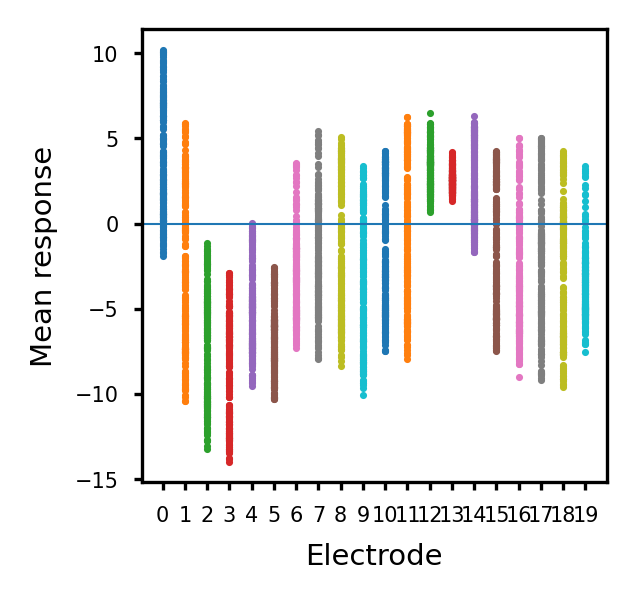

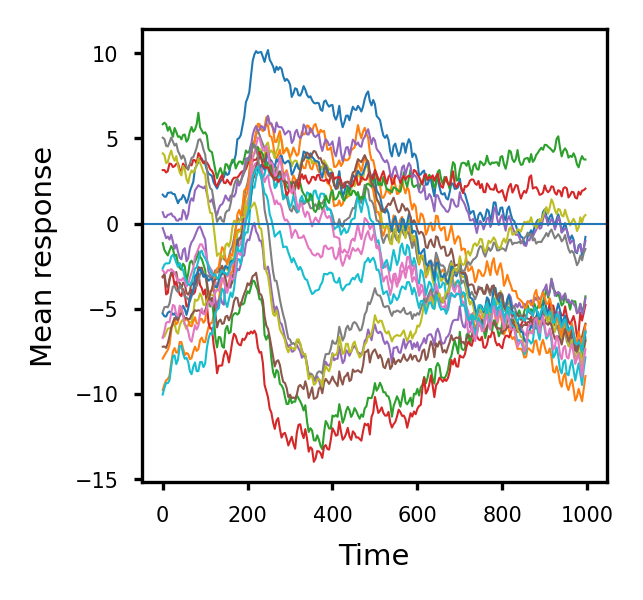

In [47]:
n_trials, n_elec, n_time = data.shape

mean_response = np.mean(data, axis=0)

fig, axs = plt.subplots(figsize=(2, 2))
for ii in range(n_elec):
    plt.scatter([ii]*n_time, mean_response[ii], s=0.5)

axs.axhline(0)
plt.xticks(list(np.arange(n_elec)))
plt.xlabel('Electrode')
plt.ylabel('Mean response')
plt.show()

fig, axs = plt.subplots(figsize=(2, 2))
plt.plot(tx, mean_response.T)

axs.axhline(0)
plt.xlabel('Time')
plt.ylabel('Mean response')
plt.show()


## That gives you an idea about what the pattern of data looks like across elmean_responseodes. 
* Next, take the mean across time separately in each electrode, so you should end up with a 960 x 20 matrix 
* Use the cond_labels vector to sort the data based on condition (so you have two 480 x 20 matrices), one matrix for each experimental condition.
* Take 90% (or thereabouts) of the data from each condition and use that as a training set. Use the remaining 10% of data from each condition as a test set. 
* Do classification to see if you can decode the experimental condition - train the model on your "training" data, and then test on the held out 10% from each condition.

In [45]:
mean_across_time = np.mean(data,axis=2)
cond_0 = mean_across_time[cond_labels==0]
cond_1 = mean_across_time[cond_labels==1]

from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
kf.get_n_splits(mean_across_time)

preds = []
acc = []
for train_index, test_index in kf.split(mean_across_time):

    x_train, y_train = mean_across_time[train_index], cond_labels[train_index]
    x_test, y_test = mean_across_time[test_index], cond_labels[test_index]

    model = SVC(kernel='linear', C=1)
    model.fit(x_train, y_train)
    
    pred = model.predict(x_test)
    preds.append(preds)
    acc.append(accuracy_score(y_test, pred))
    
    

In [46]:
print(acc)

[0.5833333333333334, 0.6458333333333334, 0.6666666666666666, 0.5833333333333334, 0.5833333333333334, 0.59375, 0.6145833333333334, 0.65625, 0.625, 0.5520833333333334]


## Now try doing this across timepoints!
* First do a time window based on where you think there is nice separation in the responses across electrodes (look at the data that you plotted above)...maybe try 300-400msec post stim and a few others...
* Bonus on your own: try timepoint x timepoint or a **moving window** (e.g. a series of 10ms bins)

In [113]:
window_size = 25
preds2 = []
acc2 = []
for ii in np.arange(0, n_time-window_size):
    kf = KFold(n_splits=5)
    kf.get_n_splits(mean_across_time[ii:ii+window_size])
    for train_index, test_index in kf.split(mean_across_time[ii:ii+window_size]):
        
        x_train, y_train = mean_across_time[ii:ii+window_size][train_index], cond_labels[ii:ii+window_size][train_index]
        x_test, y_test = mean_across_time[ii:ii+window_size][test_index], cond_labels[ii:ii+window_size][test_index]

        model = SVC(kernel='linear', C=1)
        model.fit(x_train, y_train)

        pred = model.predict(x_test)
        preds2.append(preds)
        accuracy = accuracy_score(y_test, pred)
        acc2.append(accuracy)
#         print(accuracy)

acc2 = np.array(acc2)

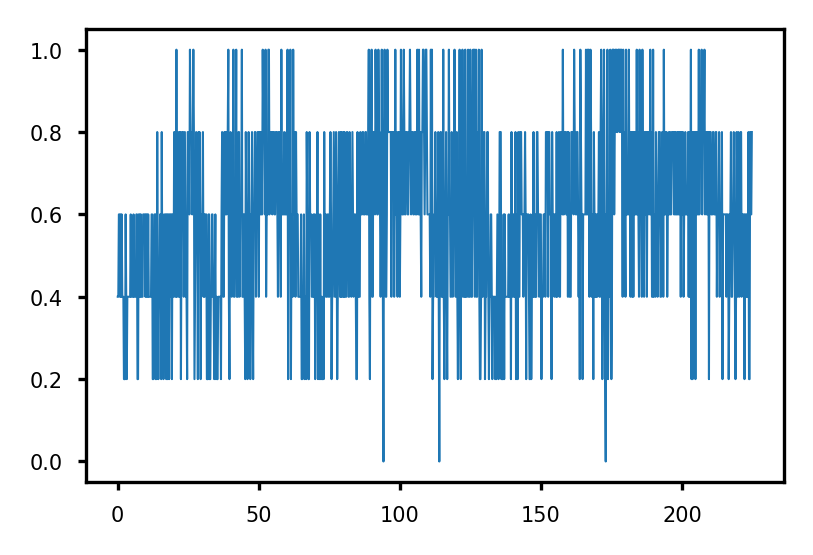

In [100]:
acc2.shape
xs = np.arange(0,1125)/5
plt.plot(xs,acc2)


In [105]:
import pandas as pd
acc_ = pd.Series(acc2)

windows = acc_.rolling(window_size)

moving_averages = windows.mean()


moving_averages_list = np.array(moving_averages)

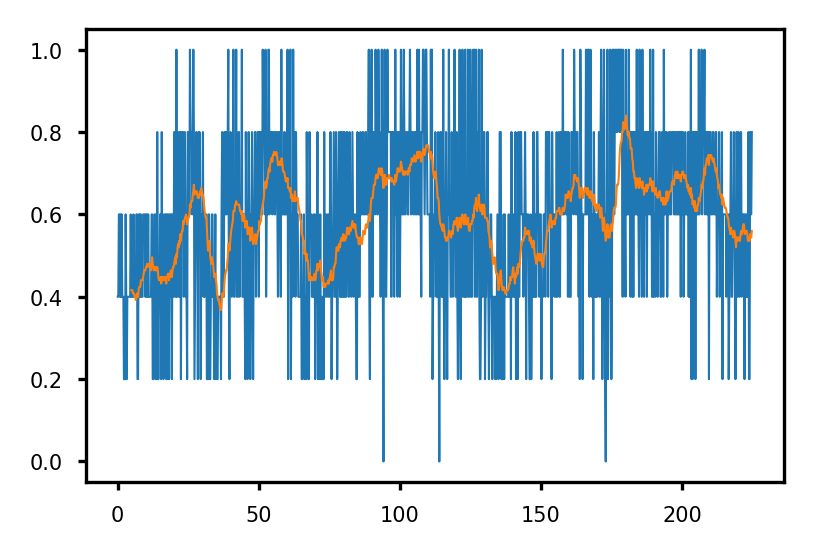

In [108]:
xs = np.arange(0,1125)/5
plt.plot(xs,acc2)
plt.plot(xs,moving_averages_list)